In [45]:
import cv2
import os
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Path to the dataset

In [3]:
dataset_path = '/kaggle/input/att-database-of-faces'

# Read images

X shape: (400, 10304)
y shape: (400,)


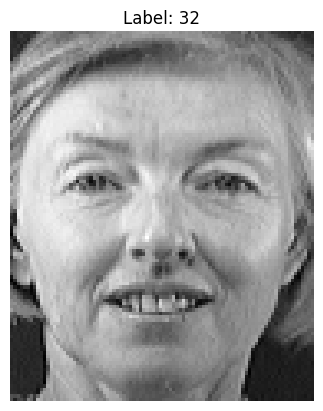

In [4]:
images = []
labels = []

for person_dir in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_dir)
    if os.path.isdir(person_path):
        label = int(person_dir[1:])
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            # Grayscale images of shape (112, 92)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Flatten the image to be has shape (112 * 92 -> 10304, )
            img_flattened = img.flatten()
            images.append(img_flattened)
            labels.append(label)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Get the shape of the dataset and its label
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Show one image
plt.imshow(X[0].reshape(112, 92), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

# Split data into training and testing data 

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

m,_ = X.shape
for i in range(0, m-1, 2):
    X_train.append(X[i])
    y_train.append(y[i])
    X_test.append(X[i+1])
    y_test.append(y[i+1])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Get the shape of the splited dataset and its label
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200, 10304)
y_train shape: (200,)
X_test shape: (200, 10304)
y_test shape: (200,)


# K-means

In [6]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X, y=None):
        self.y_true = y  # Store true labels if provided
        
        # Initialize centroids randomly from the dataset
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iters):
            # Assign each point to the nearest centroid
            self.labels = self._assign_cluster_labels(X, y)
            
            # Calculate new centroids
            new_centroids = self._calculate_centroids(X)
            
            # Check for convergence (if the centroids don't change much)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
                
            self.centroids = new_centroids

    def _assign_labels(self, X):
        # Compute distance from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # Assign labels based on closest centroid
        return np.argmin(distances, axis=1)

    def _assign_cluster_labels(self, X, y=None):
        # Compute distances and find the nearest cluster
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        if y is None:
            return cluster_indices
        else:
            # Assign majority label within each cluster
            labels = np.zeros_like(cluster_indices)
            for cluster in range(self.n_clusters):
                indices = np.where(cluster_indices == cluster)[0]
                if len(indices) > 0:
                    majority_label = Counter(y[indices]).most_common(1)[0][0]
                    labels[indices] = majority_label
            return labels

    def _calculate_centroids(self, X):
        # Calculate the mean of the points assigned to each centroid
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            points = X[self.labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    def predict(self, X):
        return self._assign_cluster_labels(X)

# Training step

In [23]:
# First, train PCA for each alpha for the training and test data
alphas = [0.8, 0.85, 0.9, 0.95]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store PCA-transformed datasets {alpha: pca data}
pca_transformed_trained_data = {}
pca_transformed_tested_data = {}

for alpha in alphas:
    pca = PCA(n_components=alpha)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    pca_transformed_trained_data[alpha] = X_train_pca
    pca_transformed_tested_data[alpha] = X_test_pca
    print(f"PCA at alpha={alpha}")
    print(f"Shape of the PCA trained data ={X_train_pca.shape}")
    print(f"Shape of the PCA tested data ={X_test_pca.shape}")
    print("="*100)

PCA at alpha=0.8
Shape of the PCA trained data =(200, 37)
Shape of the PCA tested data =(200, 37)
PCA at alpha=0.85
Shape of the PCA trained data =(200, 52)
Shape of the PCA tested data =(200, 52)
PCA at alpha=0.9
Shape of the PCA trained data =(200, 76)
Shape of the PCA tested data =(200, 76)
PCA at alpha=0.95
Shape of the PCA trained data =(200, 115)
Shape of the PCA tested data =(200, 115)


In [24]:
# Then, for each transformed dataset, train KMeans
clusters = [20, 40, 60]

# Structure: {alpha: {k: model}}
kmeans_models = defaultdict(dict)

for alpha, X_train_pca in pca_transformed_trained_data.items():
    for k in clusters:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_pca, y_train)
        kmeans_models[alpha][k] = kmeans

model = kmeans_models[0.8][40]
print(f"At alpha=0.8 and k=40 cluster labels:\n{model.labels}")

At alpha=0.8 and k=40 cluster labels:
[32 32 32 32 32 39 39 39 39 39 26 26 26 26 26 20  4 20 20 20  5 18 18 18
 18 25 25 25 25 25 24 24 24 24 24 37 22 28 37 37 18 13 12 18  5 19 16 16
 19 19 33 20 20 33 33  1  1  1  1  1 11 11 11 11 11 34 31 31 31 34 35 35
  4 26 26 13 18 18  5 13 19 16 19 19 19 39 39 20 33 20 37 37 37 37 37 10
 10 10 10 10  8  8 16 15  8  5  5  5  5  5  7  7  7  7  7 37 28 37 28 28
  9  9  8  9  9  2 15  2 15  2 21 21 21 21 21  2  2  2  2  2  6  6  6  6
  6  9 20  9 33 31 26  4  4 26 26  9  8  8  4  8  4  4  4  4  4 16 16 16
 16 16  9  8  8  9  4  9 17 17 17  9  7 17 17 17  7 22 22 22 22 22 34 34
 34 34 34 12 12 12 12 12]


# Testing step

In [30]:
predictions = defaultdict(dict)

for alpha, models_by_k in kmeans_models.items():
    # Get the PCA-transformed test data
    X_test_pca = pca_transformed_tested_data[alpha]  

    for k, model in models_by_k.items():
        y_pred = model.predict(X_test_pca)
        predictions[alpha][k] = y_pred

Alpha: 0.8, k: 20:
Accuracy: 0.05
F1-Score: 0.01


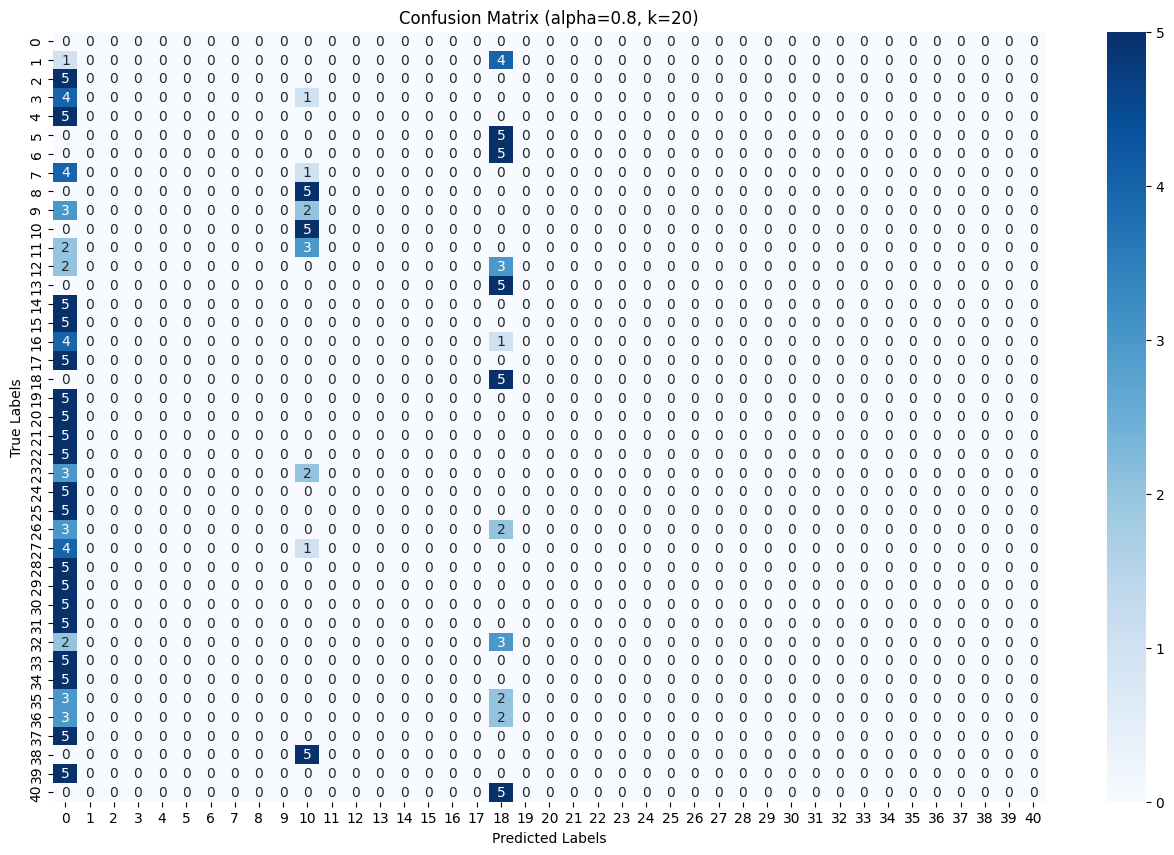

Alpha: 0.8, k: 40:
Accuracy: 0.63
F1-Score: 0.56


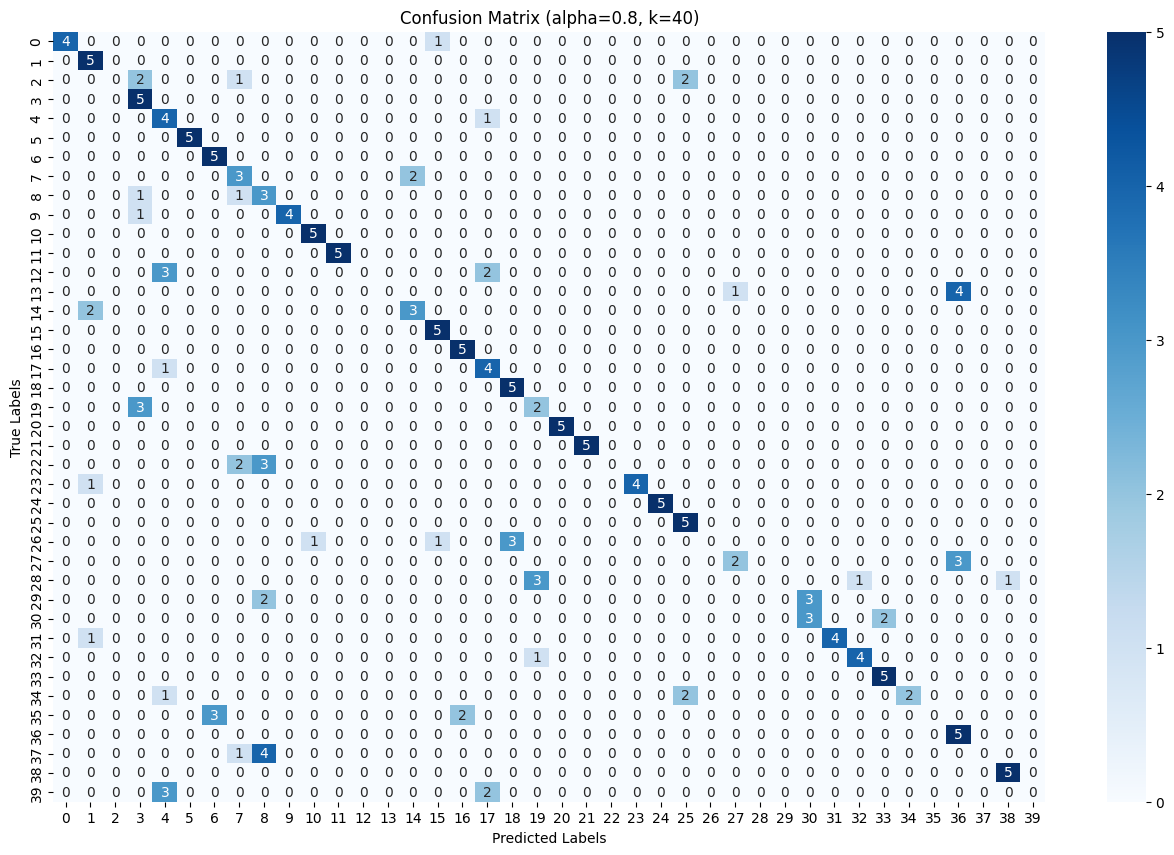

Alpha: 0.8, k: 60:
Accuracy: 0.67
F1-Score: 0.62


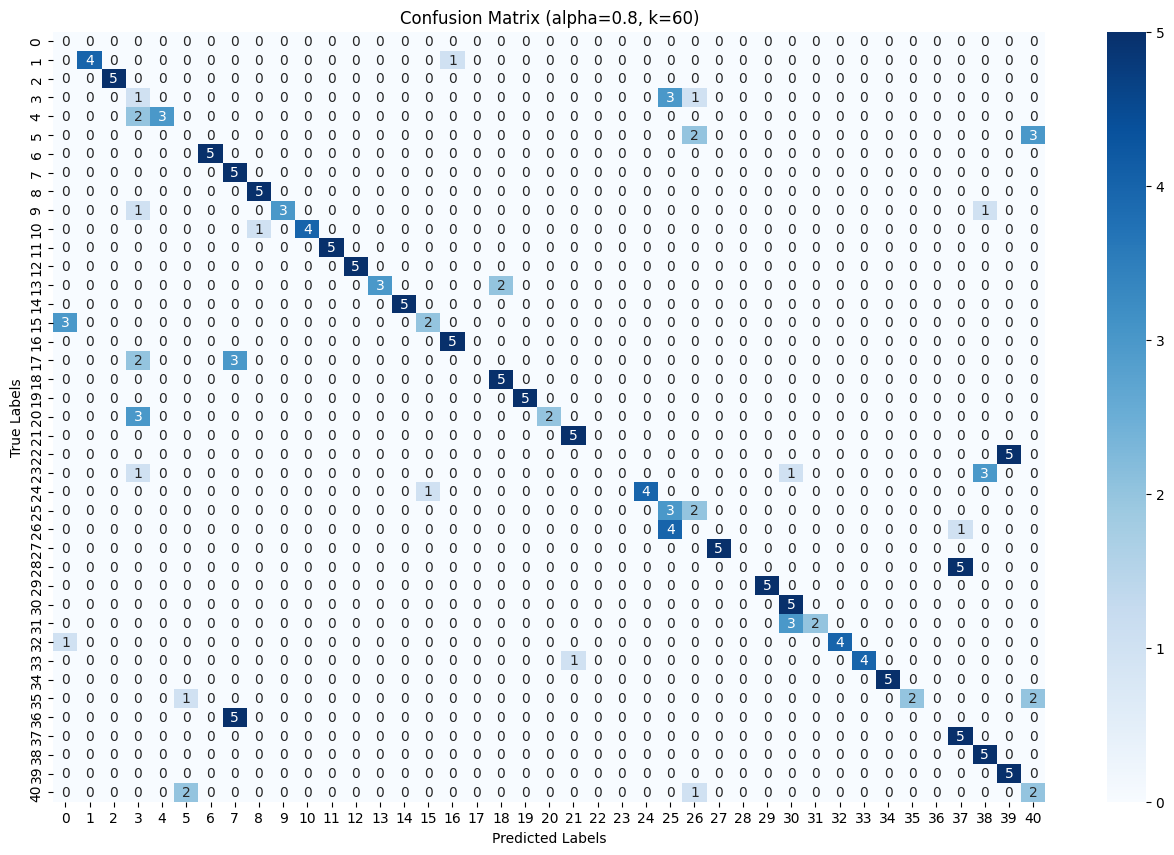

Alpha: 0.85, k: 20:
Accuracy: 0.07
F1-Score: 0.05


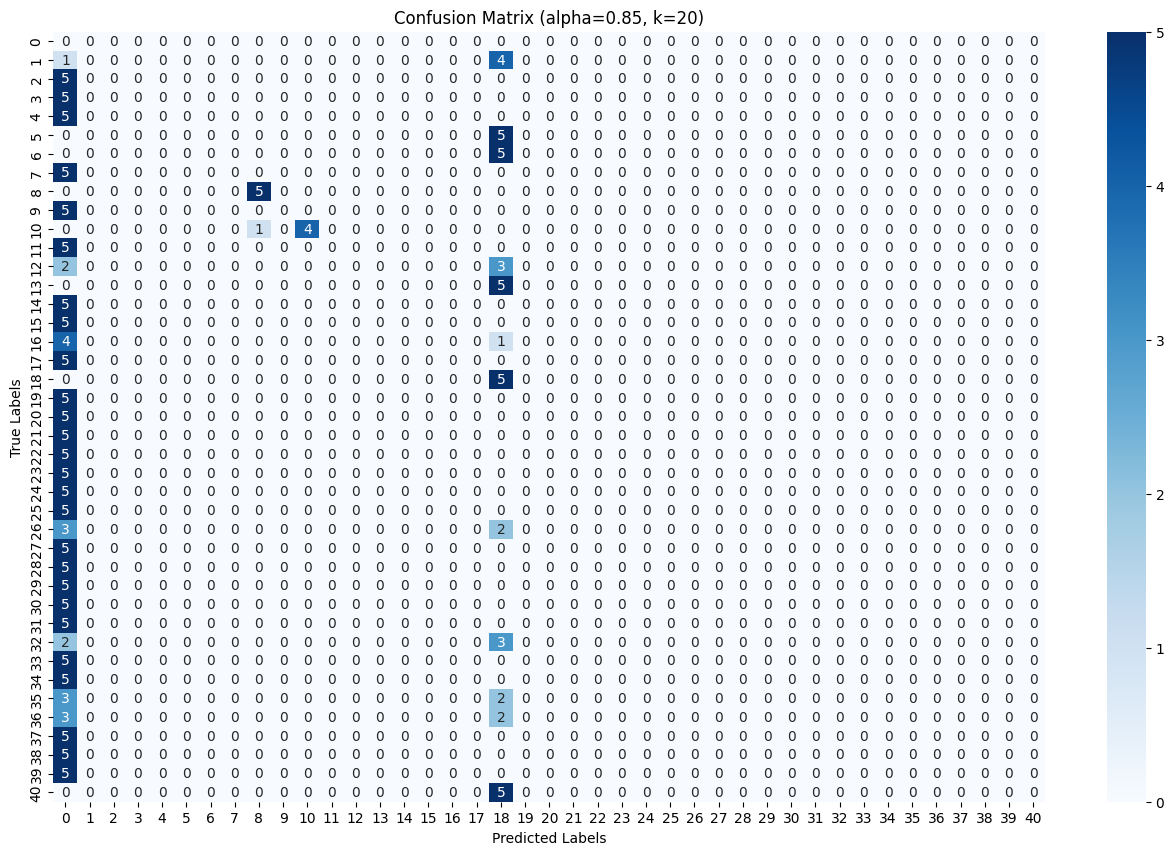

Alpha: 0.85, k: 40:
Accuracy: 0.58
F1-Score: 0.50


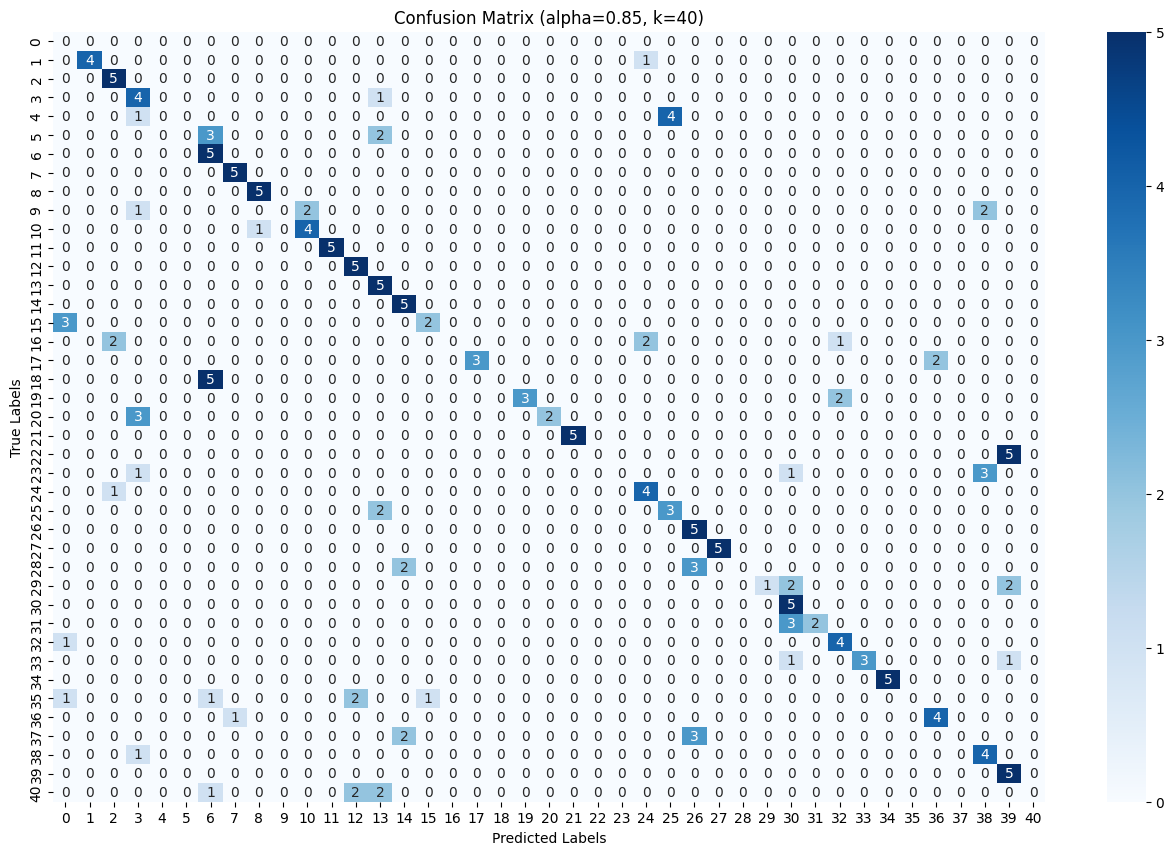

Alpha: 0.85, k: 60:
Accuracy: 0.72
F1-Score: 0.67


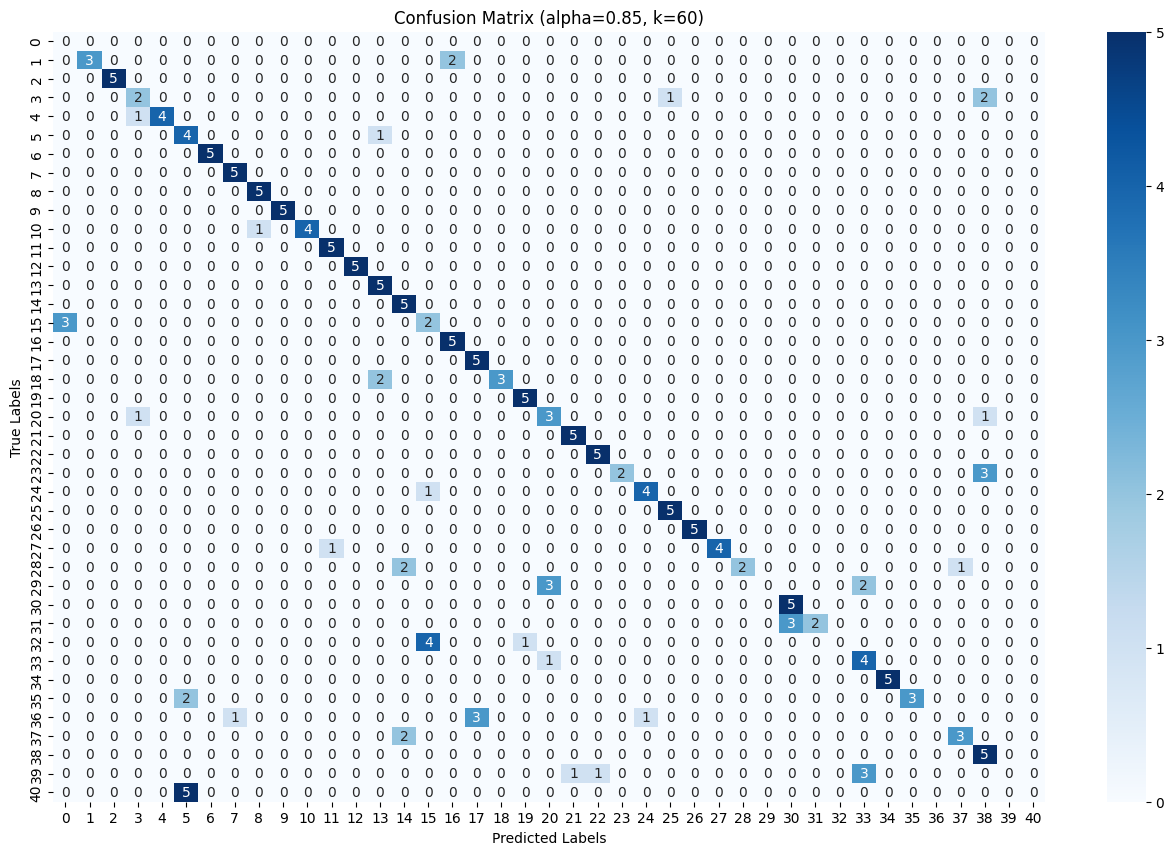

Alpha: 0.9, k: 20:
Accuracy: 0.07
F1-Score: 0.03


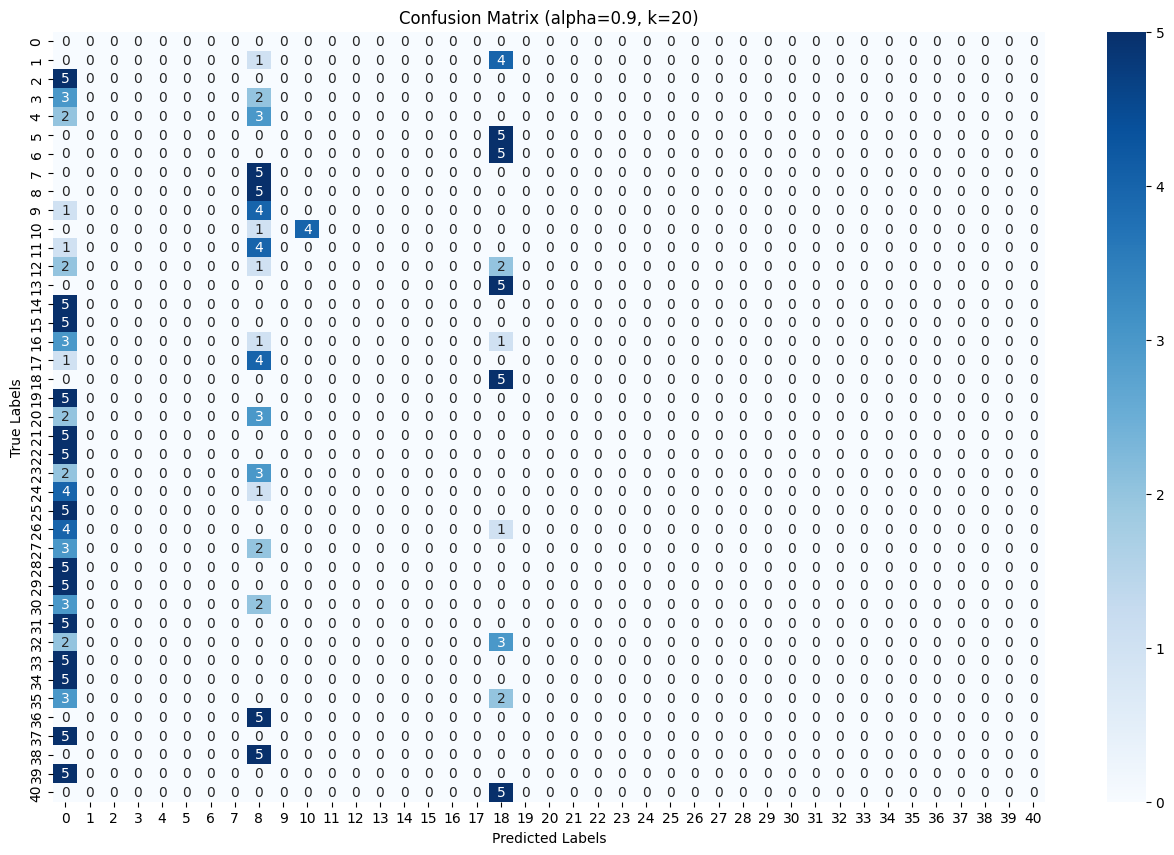

Alpha: 0.9, k: 40:
Accuracy: 0.57
F1-Score: 0.49


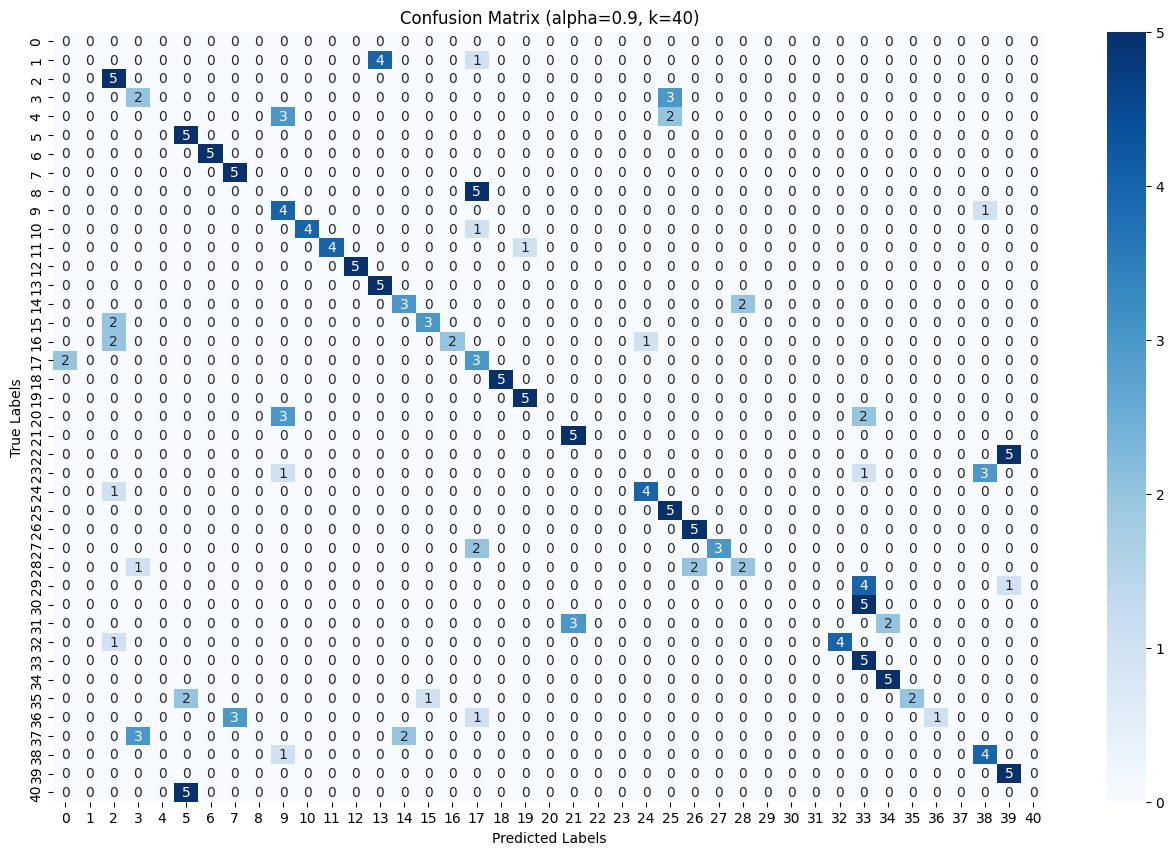

Alpha: 0.9, k: 60:
Accuracy: 0.69
F1-Score: 0.64


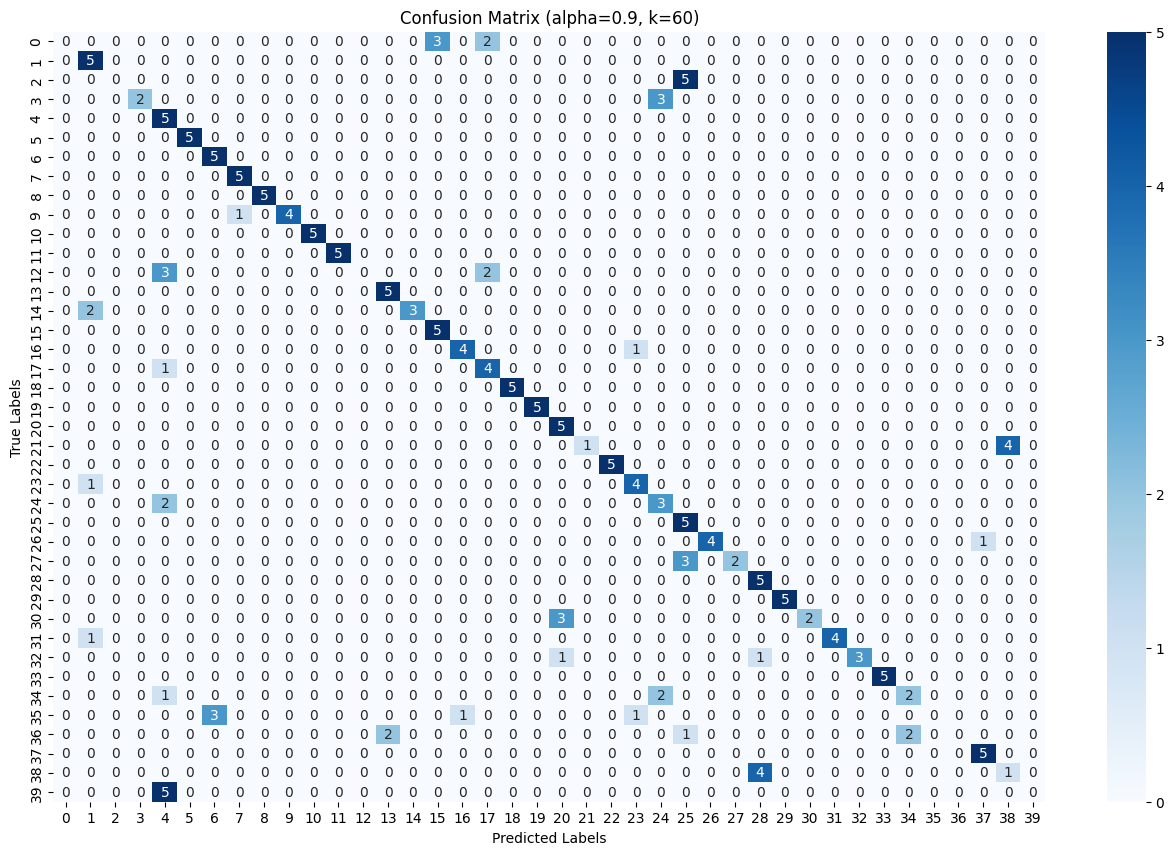

Alpha: 0.95, k: 20:
Accuracy: 0.05
F1-Score: 0.03


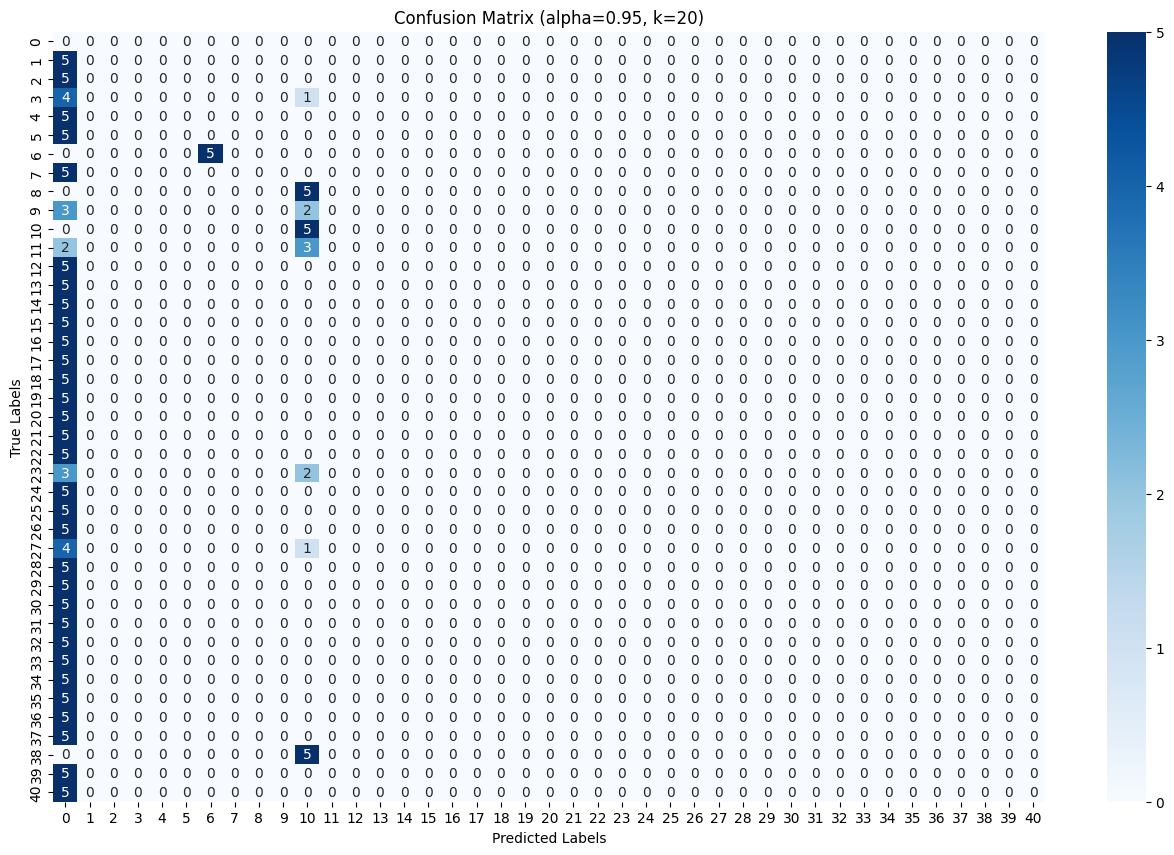

Alpha: 0.95, k: 40:
Accuracy: 0.60
F1-Score: 0.54


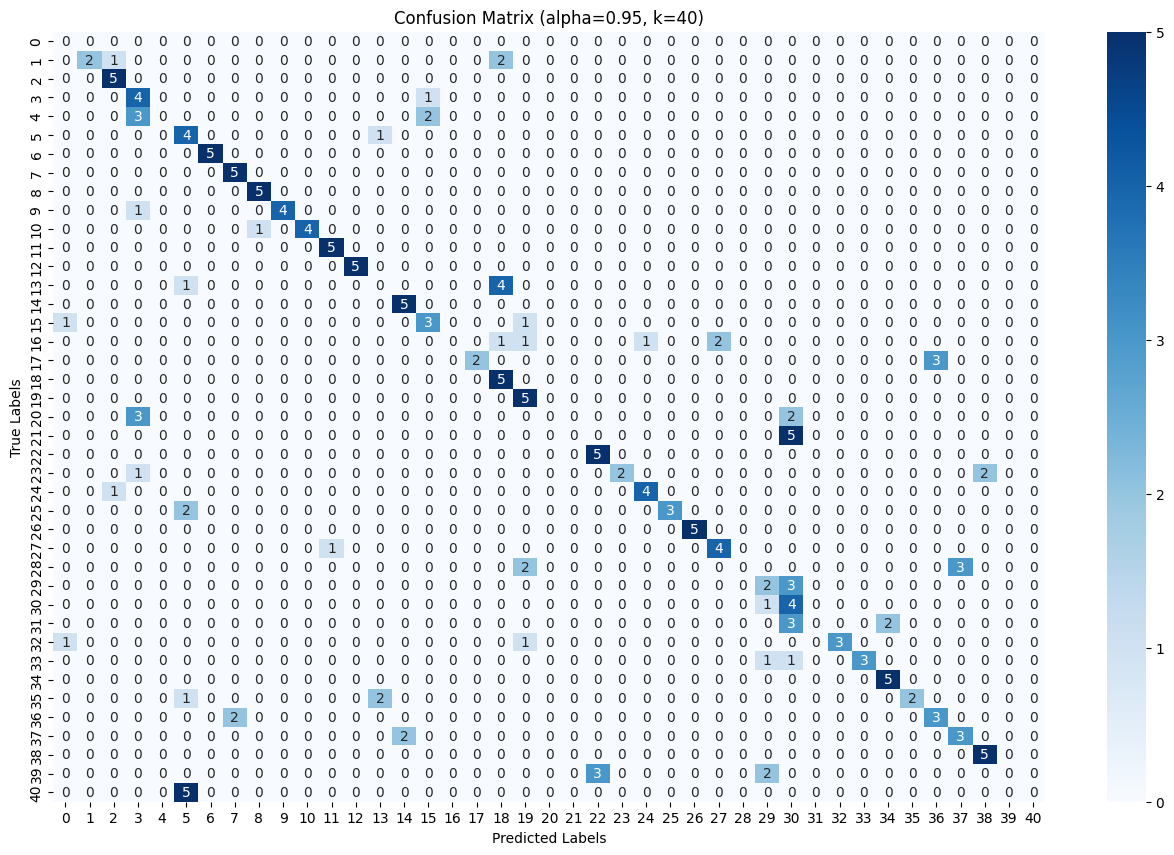

Alpha: 0.95, k: 60:
Accuracy: 0.71
F1-Score: 0.66


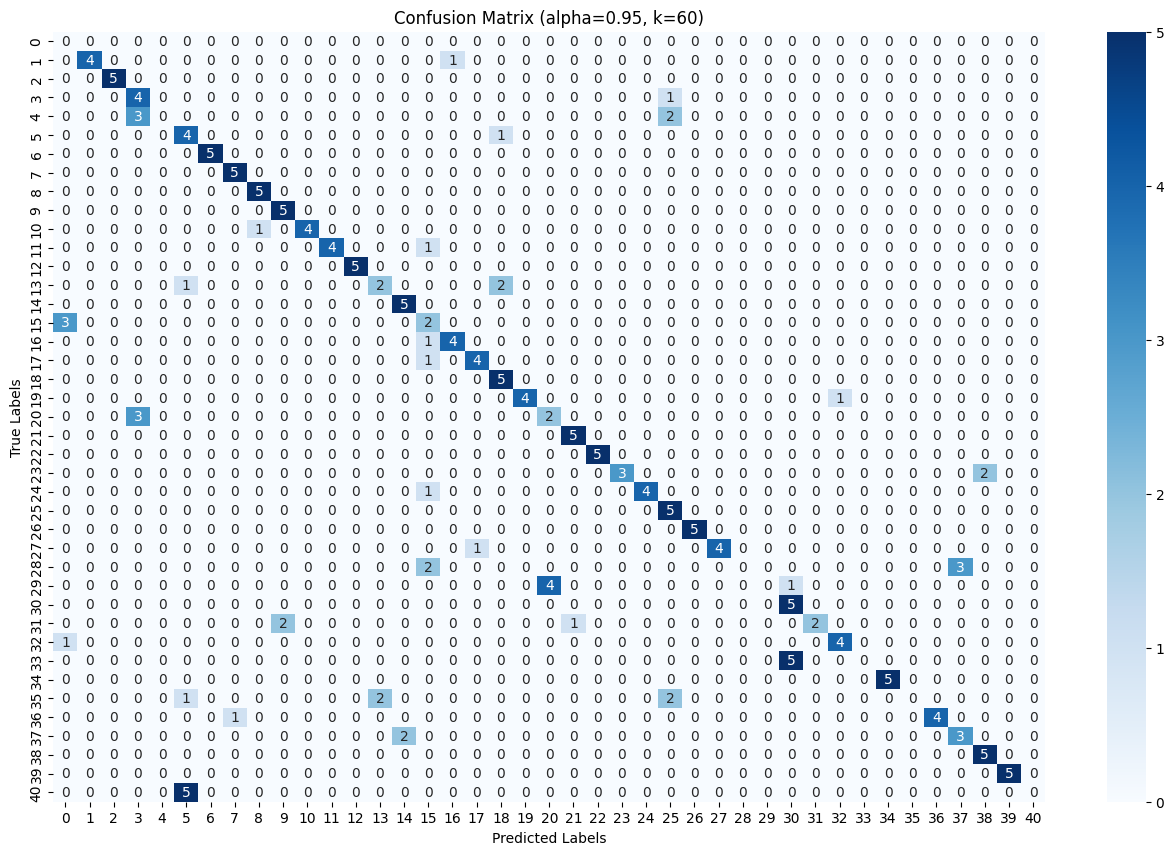

In [47]:
accuracy_results = defaultdict(dict)

for alpha, preds_by_k in predictions.items():
    for k, y_pred in preds_by_k.items():
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[alpha][k] = acc
        
        f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
        
        cm = confusion_matrix(y_test, y_pred)

        print(f"Alpha: {alpha}, k: {k}:")
    
        # Accuracy
        print(f"Accuracy: {acc:.2f}")
        
        # F1-score
        print(f"F1-Score: {f1:.2f}")
        
        # Confusion Matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix (alpha={alpha}, k={k})")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


In [48]:
# Flatten the dictionary into a list of results
results = []
for alpha, preds_by_k in accuracy_results.items():
    for k, acc in preds_by_k.items():
        results.append({'alpha': alpha, 'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    alpha   k  accuracy
0    0.80  20     0.050
1    0.80  40     0.630
2    0.80  60     0.665
3    0.85  20     0.070
4    0.85  40     0.585
5    0.85  60     0.720
6    0.90  20     0.070
7    0.90  40     0.575
8    0.90  60     0.690
9    0.95  20     0.050
10   0.95  40     0.605
11   0.95  60     0.710


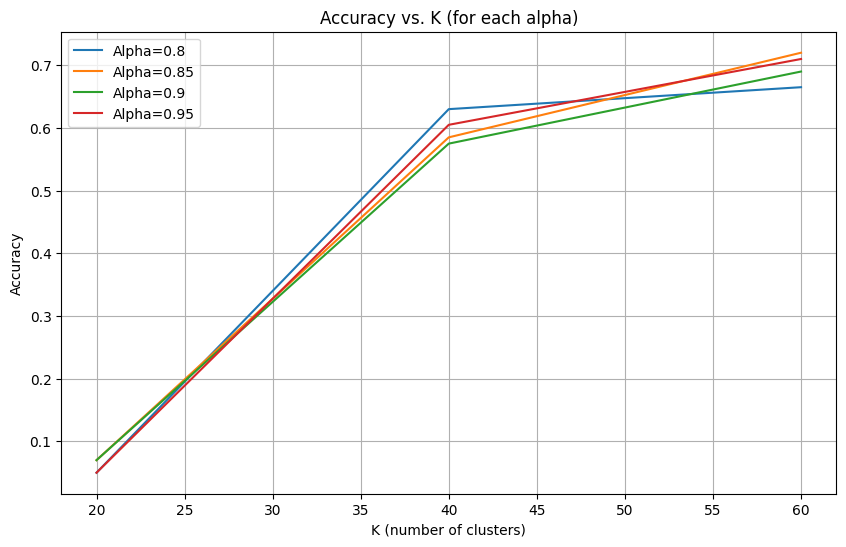

In [49]:
# Plot accuracy for different K values for each alpha
plt.figure(figsize=(10, 6))

for alpha in accuracy_results:
    ks = list(accuracy_results[alpha].keys())
    accuracies = list(accuracy_results[alpha].values())
    plt.plot(ks, accuracies, label=f'Alpha={alpha}')

plt.xlabel('K (number of clusters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K (for each alpha)')
plt.legend()
plt.grid(True)
plt.show()

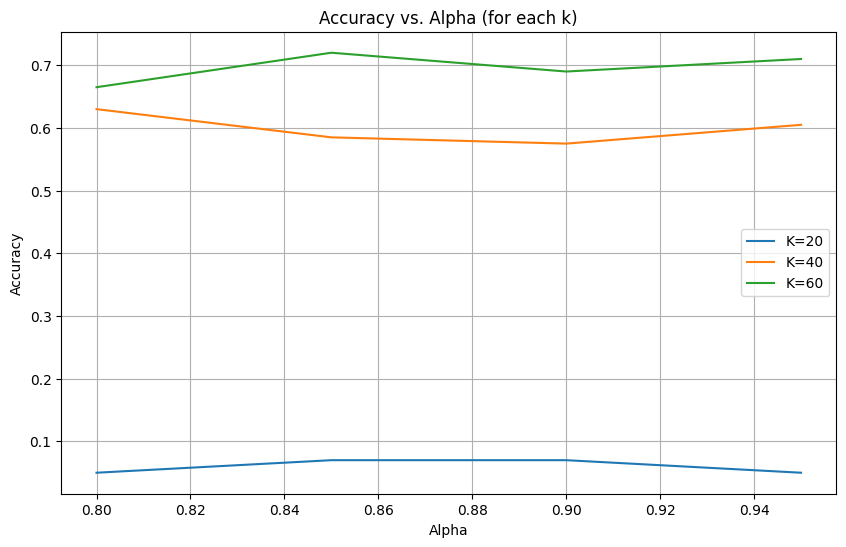

In [51]:
# Plot accuracy for different alpha values for each k
plt.figure(figsize=(10, 6))

for k in accuracy_results[next(iter(accuracy_results))]:  # Assuming k exists for all alphas
    alphas = list(accuracy_results.keys())  # List of alpha values
    accuracies = [accuracy_results[alpha][k] for alpha in alphas]  # Accuracy for each alpha for this k
    plt.plot(alphas, accuracies, label=f'K={k}')

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha (for each k)')
plt.legend()
plt.grid(True)
plt.show()